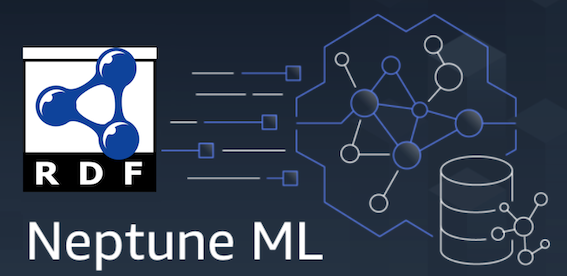

# Getting started with Neptune ML
This notebook provides an overview of the Amazon Neptune ML feature and how you can use it in a property graph to infer missing data.  All that you will need to have available to run this tutorial is an Amazon Neptune Cluster with Neptune ML enabled and an S3 bucket in the same region.  


<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This tutorial will cost ~$2-3/hour in addition to the cost of your Neptune cluster and will take approximately 30 minutes to complete</div>


Graphs and graph data is all about using the values and connections within that data to provide novel insight.  However one common issue with graph data is that it is frequently incomplete, meaning that it contains missing property values or connections.  While incomplete data is not unique to graphs the connected nature how we want to use graph data makes these gaps even more impactful, usually lead to inefficent traversals and/or incorrect results.  Neptune ML was released to help mitigate these issues by integrating Machine Learning (ML) models into real time graph traversals to predect/infer missing graph elements such as properties and connections.  

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy to use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. These models cover many common use cases such as:

* [Identifying fradulent transactions](https://aws.amazon.com/blogs/machine-learning/detecting-fraud-in-heterogeneous-networks-using-amazon-sagemaker-and-deep-graph-library/)
* Predicting group membership in a social or identity network
* Predicting categories for product recommendation
* Predicting user churn

Neptune ML accomplishes this by providing the ability to perform several common machine learning tasks within Neptune using the SPARQL query language.  These tasks include:

### Classification
* **Object Classification** - The ability to predict an rdf:Literal value for the 'object' of the <subject, predicate, object> RDF model from a finite set of options.  Object classification can be used for situations such as determining if a transaction is fraudulent, detemining what sort or product a person is most likely to purchase, or predicting a persons age or occupation.

### Regression
* **Object Regression** - The ability to predict a numerical rdf:Literal value for the 'object' of the <subject, predicate, object> RDF model, such as a user's credit score or how a person might rate a movie.

### Link Prediction
* **Object Prediction** - The ability to predict an rdf:IRI 'object' of the <subject, predicate, object> RDF model.  This can be used to solve problems such as finding friends within a social network, recommending products to a user, or determining if a person is a member of a fraud ring.
* **Subject Prediction** - The ability to predict an rdf:IRI 'subject' of the <subject, predicate, object> RDF model.  This can be used to solve problems such as finding friends within a social network, recommending products to a user, or determining if a person is a member of a fraud ring. 

To accomplish this in Neptune ML we use a four step process:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as the SPARQL queries or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.  Neptune ML achieves this by automating the normal machine learning process of dividing data into training, validation, and test sets.  It then  uses training dataset is used to build the model, the validation dataset to validate the model and determine which of the best model, and then estimate the model's accuracy using the test dataset.  Using these steps Neptune ML simplifies the overall model building process by automatically returning the best model possible for the configuration provided.
4. **Run Queries** - The final step is to use this inference endpoint within our SPARQL queries to infer data using the machine learning model.

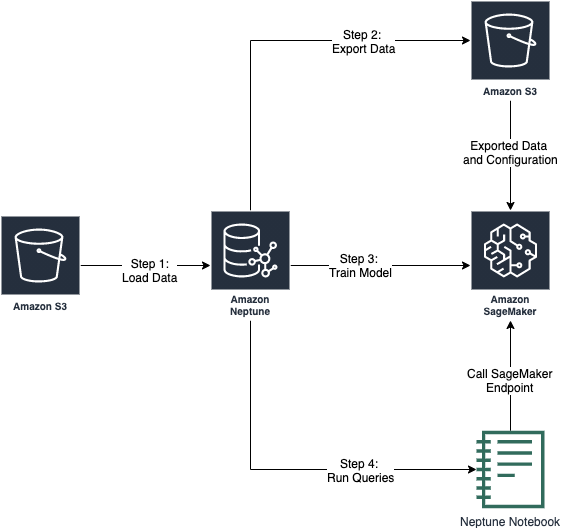

Running through this process can take quite awhile (e.g. hours) to complete. To speed up your ability to try out each of this feature we've provided a set of pretrained models for use with this notebook. These pretrained models eliminate the need for you to perfom most of the long running steps (Export, Data Processing, and Model training) but will still allow you to see the end benefits of inferring data during SPARQL queries.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: To run through these steps yourself use one of the three "Introduction to (Object Classification/Object Regression/Link Prediction)" notebooks, located in the 04-Machine-Learning/Neptune-ML-SPARQL directory, that matches your use case.</div> 

Please note that the notebook entitled 'Neptune-ML-03-Introduction-to-Link-Prediction-SPARQL' Link Prediction runs through both Subject Prediction and Object Prediction examples, as these are both examples of how to perform the common machine learning task of Link Prediction in SPARQL and RDF.

These pre-trained models use the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) provided by [GroupLens Research](https://grouplens.org/datasets/movielens/). This dataset consists of movies, users, and ratings of those movies by users. 

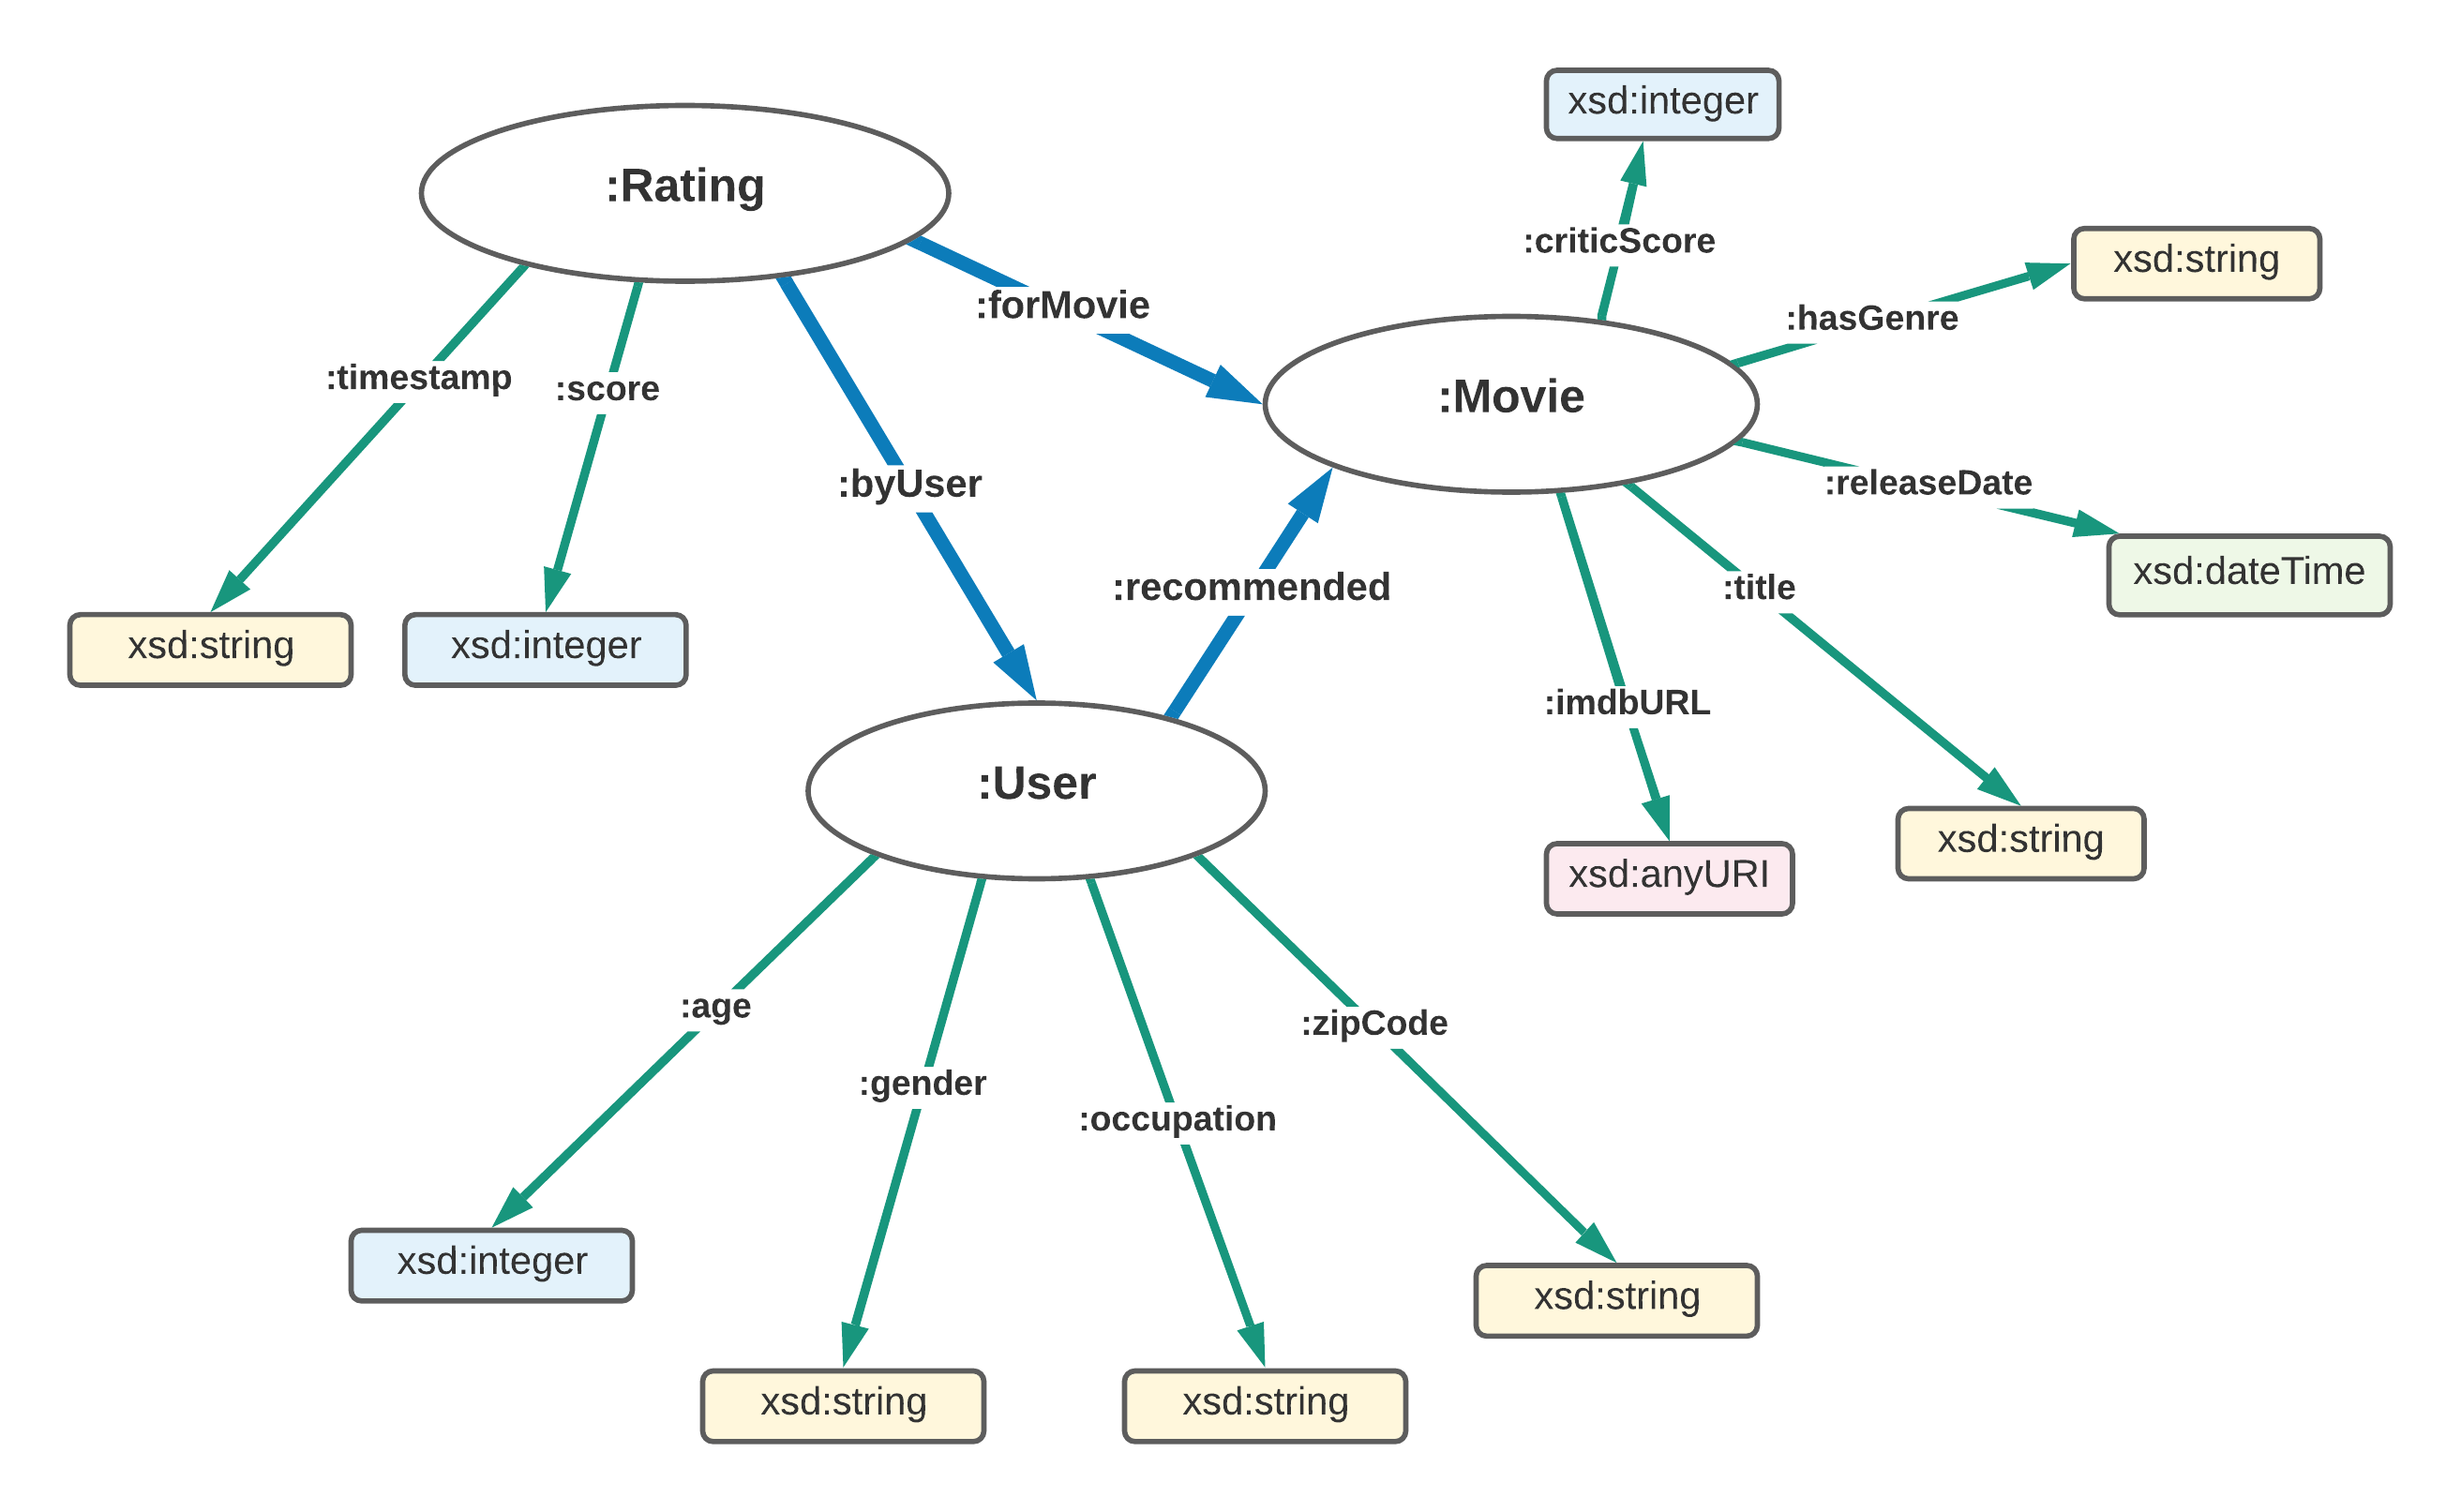

## Checking that we are ready to run Neptune ML 
Run the code below to check that your cluster is configured to run Neptune ML.

In [ ]:
import neptune_ml_sparql_utils as neptune_ml
neptune_ml.check_ml_enabled()

If the check above did not say that this cluster is ready to run Neptune ML jobs then please check that the cluster meets all the pre-requisites defined [here](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview).

## Loading data 

The first step in building a Neptune ML model is to load data into the Neptune cluster. Loading data for Neptune ML follows the standard process of ingesting data into Amazon Neptune, for this example we'll be using the Bulk Loader. 

We have written a script that automates the process of downloading the data from the MovieLens websites and formatting it to load into Neptune. All you need to provide is an S3 bucket URI that is located in the same region as the cluster.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This is the only step that requires any specific input from the user, all remaining cells will automatically propogate the required values.</div>

In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

Now that you have provided an S3 bucket, run the cell below which will download and format the MovieLens data into a format compatible with Neptune's bulk loader.

In [ ]:
response = neptune_ml.prepare_movielens_data_rdf(s3_bucket_uri, clear_staging_area=True)

This process only takes a few minutes and once it has completed you can load the data using the `%load` command in the cell below.

In [ ]:
%load -s {response} -f nquads -p OVERSUBSCRIBE --run


## Configuring the Endpoints

Now that we have confirmed that our cluster is setup for Neptune ML let's create our endpoints for each model type from our pre-trained models.  As we stated, we have provided a set of pretrained models, one for each model type provided by Neptune ML.  When you generate a model there are a few key items to understand:

* Each model is trained to perform one task only.  e.g. rdf:Object classification, rdf:Object regression and Link prediction will each be their own model.
* For rdf:Object classification, rdf:Object regression and Link prediction the property you want to infer is specified at the time the model is built, this is the only property that model can infer.
* The models only work on elements of the graph that existed at the time the model was built, known as a transductive model.  Newly added elements cannot be used until the model is retrained or the model has been transformed to work against newly added data as well.

Each of these models is trained and configured to allow for performing a specific task.

Object Classification - This model is trained to allow for inferring the `genre` property of a the `Movie` class.
Object Regression - This model is trained to allow for inferring the `criticScore` property of a `Movie` class.
Link Prediction - This model will be used to infer `:recommended` relationships between the `User` and a `Movie` classes.

To simplify setting this up we have provided some python code below to load the MovieLens data into the Neptune Cluster and setup the five endpoints.  With this code there are several configuration options you can choose:

* Each task type is configured to be created by default.  If you would like to not setup one or more task types then please set the variable to `False` for that task. e.g. To not create a node classification endpoint set `setup_object_classification=False`
* Each endpoint created has an associated hourly charge so please ensure you delete them when finished, either using the `Cleaning Up` cell below or via the Amazon Web Services Console -> Amazon SageMaker -> Endpoints.

In the cell below you need to provide an S3 bucket that will be used to maintain the model artifacts.  After you have configured the cell below, run the cell, and the associated endpoints will be created.  This will take 5-10 minutes to complete.  

In [ ]:
setup_object_classification=True
setup_object_regression=True
setup_link_prediction=True

endpoints=neptune_ml.setup_pretrained_endpoints_rdf(s3_bucket_uri, setup_object_classification, setup_object_regression, setup_link_prediction)

In [ ]:
object_classification_endpoint=endpoints['object_classification_endpoint_name']['EndpointName']
object_regression_endpoint=endpoints['object_regression_endpoint_name']['EndpointName']
link_prediction_endpoint=endpoints['link_prediction_endpoint_name']['EndpointName']

Once this cell has completed we have the endpoint names for our newly created inference endpoints, which will be used in the configuration of each SPARQL query.  

In your use case the models will require configuration and training parameter adjustments to maximize the accuracy of the inferences they generate.  These pretrained models use the default parameters to demonstrate the base accuracy of the models prior to tuning.  Additional information on how to tune these models via the links below:

* [Training File Configuration](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-processing-training-config-file.html)
* [Tuning Hyperparameters](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-customizing-hyperparams.html)
* [Improving Model Performance](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-improve-model-performance.html)

# Querying using SPARQL

Now that we have built our inference endpoints constructed let's see how we can use these to infer data within our SPARQL queries.  Let's start with 'object classification'.

## Object Classification
Object classification is the ability to infer missing property data from a finite set of options.  Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict categorical property values by predicting the the genre for movies where a genre does not already exist.
    
   Example `resource:movie_225` `ontology:genre` `"[to be predicted]"` . 
   
In order to make our prediction, we need to remove some data.  
Run the following query to remove the Genre's for three Movie's: 

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

DELETE {
    ?movie  ontology:hasGenre ?genre
}
WHERE { 
    ?movie  ontology:hasGenre ?genre ;
            ontology:title  ?title .
            
    FILTER (?title IN (
        "Empire Strikes Back, The (1980)",
        "Mars Attacks! (1996)",
        "Independence Day (ID4) (1996)"
    ))
}

Now that we have run the above query, three movies do not have any Genre's classified against them.

Run the following query to verify that the Genre's in question were removed:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre WHERE { 
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    OPTIONAL {
          ?movie  ontology:hasGenre ?genre .
    }
    
    FILTER (?title IN (
        "Empire Strikes Back, The (1980)",
        "Mars Attacks! (1996)",
        "Independence Day (ID4) (1996)"
    ))

}  

As expected there is no Genre in the result set, so let's modify this query to predict these now missing Genre's.  
To accomplish this we need to add more statements to our query.  

The following query includes a `SERVICE` enclosure to federate the Query to our ML endpoint, using a special pre-defined URI which we have designated to use for ML calls:
`SERVICE <http://aws.amazon.com/neptune/vocab/v01/services/ml#inference> {...} `  

For more detail on these additional statements, see the Object Classification notebook entitled:  
**Neptune-ML-01-Introduction-to-Object-Classification-SPARQL**

Run the following query to predict the missing Genres for `Empire Strikes Back, The (1980)` using the machine learning model:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_classification_endpoint}" ;
                         # the optional 'score' predicate   
                         ml:outputScore ?score ;
                         # the optional 'limit' predicate   
                         ml:limit "1" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ; 
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

Looking at the results, this prediction seems right for the top result, Empire Strikes Back, The (1980) seems to fit well into the Drama genre. 
However, we may want to predict more than one genre for the movie. By editing the query and changing the `ml:limit` we can ask for 3 results:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_classification_endpoint}" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

##### We now have 3 results, but not filtered by any level of confidence.

The query returns the top 3 genres, regardless of how confident the machine learning model is of its accuracy.  
Now lets try to filter the results, in order to only return results which pass a certain 'threshold'

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_classification_endpoint}" ;
                         ml:outputScore ?score ;
                         ml:threshold "0.50D" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

Note the `ml:threshold "0.17D"` in the `SERVICE { ... }` enclosure.  
The above query will return a maximum of three results (`limit "3"`), as long as the machine learning model is at least 50% confident of the prediction (`ml:threshold "0.50D"`).

The threshold is based on a score which is always available with any prediction.
Try the query below to expose what the confidence 'score' is for each result. Look for `ml:outputScore ?score` in the `SERVICE { ... }` enclosure.


In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    OPTIONAL {
          ?movie  ontology:hasGenre ?genre .
    }
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_classification_endpoint}" ;
                         ml:outputScore ?score ;
                         ml:threshold "0.50D" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

We can also apply the same filters shown above to this query to find the top 3 genres for all our "new" movies, as long as the prediction above a specfic confidence.

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    MINUS {
          ?movie  ontology:hasGenre ?existingGenre .
    }
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_classification_endpoint}" ;
                         ml:outputScore ?score ;
                         ml:threshold "0.50D" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} limit 10

Now that we have taken a look at the basics of node classification, let's move on to take a look at our next type of Neptune ML task, node regression.

## Node Regression

Node regression is the ability to infer missing property data where that data is a numerical value. The need to predict rating values in a product knowledge graph is commonly used to provide recommendations for products that a customer might want by predicting the products they will rate highest.

For our pretrained models this means we can infer the `:criticScore` for Movies.  
To demonstrate this let's use our newly created node regression endpoint to see the predicted `criticScore` for a Movie.

Before we predict it, let's ensure that it does not already exist, buy running the following query:

In [ ]:
%%sparql
PREFIX  : <http://aws.amazon.com/neptune/ontology/>
PREFIX resource: <http://aws.amazon.com/neptune/resource#>

DELETE {
    ?movie :criticScore ?score
}
WHERE {
    
    ?movie  :criticScore ?score;
            :title       'Pretty Woman (1990)' ;
            
}

Now, lets run the following query to validate that the :criticScore is indeed empty:

In [ ]:
%%sparql
PREFIX  : <http://aws.amazon.com/neptune/ontology/>
PREFIX resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?score WHERE {
    
    BIND('Pretty Woman (1990)' as ?title)

    ?movie :title ?title .
        
    OPTIONAL { ?movie :criticScore ?score  }
    
}

As expected this returned no `:criticScore` value, so let's modify this query to predict the `:criticScore` that the critics will give to this movie. To accomplish this we need to add more statements to our query.  

The following query includes a `SERVICE` enclosure to federate the Query to our ML endpoint, using a special pre-defined URI which we have designated to use for ML calls:
`SERVICE <http://aws.amazon.com/neptune/vocab/v01/services/ml#inference> {...} `  

For more detail on these additional statements, see the Object Regression notebook entitled:  
**Neptune-ML-01-Introduction-to-Object-Regression-SPARQL**

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>
PREFIX  : <http://aws.amazon.com/neptune/ontology/>

SELECT ?title ?score WHERE { 
    
    BIND('Pretty Woman (1990)' as ?title)

    ?movie :title ?title .
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${object_regression_endpoint}" ;
                         ml:modelType 'OBJECT_REGRESSION' ; 
                         ml:input ?movie ; 
                         ml:predicate :criticScore ;  
                         ml:output ?score ;
    }     
} 

Now that we've seen how node regression, let's move on to the next Neptune ML task, link prediction.

## Link Prediction

Link prediction is a unsupervised machine learning task where a model built using existing RDF statements where the ``rdf:Statement`` is a relationship between two IRI's.
This model is then used to predict other statements.

For example, if we already have data that says....  
``user:John :recommended movie:StarTrek``  
``user:John :recommended movie:BladeRunner``  

.. maybe the machine learning model would predict that ``user:John`` should also be ``recommended`` to see ``movie:StarWars``:  

* prediction  
``user:John :recommended movie:StarWars`` 

Run the following query to ensure we have no `:recommended` relationships for 2 movies and 2 users:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>
PREFIX  : <http://aws.amazon.com/neptune/ontology/>

DELETE {
    ?user :recommended ?movie .
}
WHERE {
    {
        ?user :recommended ?movie .
        FILTER (?movie IN (resource:movie_255, resource:movie_69))
    }
    UNION 
    {
        ?user :recommended ?movie . 
        FILTER (?user IN (resource:user_101, resource:user_681))
    }
} 

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>
PREFIX  : <http://aws.amazon.com/neptune/ontology/>

select * where {

    resource:user_101 :recommended ?anything

} limit 10

Now we have removed these statmemts form the database, we can run the following query which uses the link prediction endpoint to `:recommend` a movie to a user, by running the following query:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>
PREFIX  : <http://aws.amazon.com/neptune/ontology/>

select ?movie ?score WHERE { 
    
    BIND(resource:user_101 as ?user)

    ?user a :User .
        
    ?movie :title ?title .
            
    SERVICE ml:inference { 
               ml:config ml:endpoint "${link_prediction_endpoint}" ;
                         ml:modelType 'OBJECT_PREDICTION' ;
                         ml:limit 10 ;
                         ml:outputScore ?score ;
                         ml:threshold '0.1D' ;
                         ml:input ?user ; 
                         ml:predicate :recommended ;  
                         ml:output ?movie ;
                         ml:outputClass :Movie ;
    }
        
} order by desc(?score) limit 10


With that we have sucessfully been able to show how you can use link prediction to predict relationshipis between IRI's in RDF using SPARQL.

# Cleaning Up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.


In [ ]:
neptune_ml.delete_pretrained_endpoints(endpoints)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.